<a href="https://colab.research.google.com/github/madaime2/Novel_Pollen_Phylogenetic_Placement/blob/main/00_Training_and_Classification/03_Pollen_Classification_Four_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

absolute_path = os.path.dirname("/content/drive/MyDrive/Podocarpus_Final/Podocarpus_Project/")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# BEGIN HERE (NAIVE CLASSIFIER)

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
 
torch.manual_seed(3)
data_transforms = {
    'train': transforms.Compose([
       # transforms.RandomResizedCrop(224),
         torchvision.transforms.Resize((224,224)),
 
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation((-90,90)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
       # transforms.Resize(256),
       torchvision.transforms.Resize((224,224)),
       # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = absolute_path + "/Podocarpus_Stacks_Split04"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Load C-CNN

In [ ]:
PATH = absolute_path + "/models/Podocarpus_C-CNN_Split04.pt"
model =  models.resnext101_32x8d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names)); 
model.load_state_dict(torch.load(PATH));
#model.load_state_dict(torch.load(PATH, map_location="cpu"))
model.to(device);

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

# Forward-pass validation images (cross-sectional images)

In [ ]:
# Forward Pass Images to the network to get (1) Softmax probabilities and (2) best classification prediction

# Average Logits first, then pass the new logit (average) to the softmax function

# Each instance is a subfolder containing multiple (N) cross-sectional images (slices belonging to the original image stack)


mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])


import glob
from PIL import Image

transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

def predict(model, image_dir):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))
    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    logits = model(images)
    logits = logits.detach().cpu().numpy()
    logits = torch.tensor(logits)
    logits_mean = logits.mean(0)
    probs = torch.softmax(logits_mean, 0).detach().cpu().numpy()
    # Compute average and get final prediction
    # avg_probs = probs.mean(0)
    avg_probs = probs
    final_pred = avg_probs.argmax()
    return final_pred, avg_probs

val_dir = absolute_path + "/Podocarpus_Stacks_Split04/val"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))
model.eval()
class_map = {name: idx for idx, name in enumerate(class_names)}
results = []
all_preds = []
labels = []
all_image_dirs = []

for d in val_class_dirs:
    image_dirs = glob.glob(os.path.join(d, '*'))
    for image_dir in image_dirs:
        class_name = os.path.basename(image_dir).split('.')[0]
        label = class_map[class_name]
        labels.append(label)
        all_image_dirs.append(image_dir)  
        class_id, probs = predict(model, image_dir)
        all_preds.append(probs)
        results.append((image_dir, class_id))
        #print(f'Predict {image_dir} as class {class_id}')

all_preds = np.stack(all_preds, 0)
labels = np.array(labels)
print(all_preds.shape, all_preds.dtype, labels.shape, labels.dtype)
print('Accuracy: {}'.format((all_preds.argmax(1) == labels).mean()))

(100, 30) float32 (100,) int64
Accuracy: 0.93


# Compute and visualize confusion matrix (C-CNN)

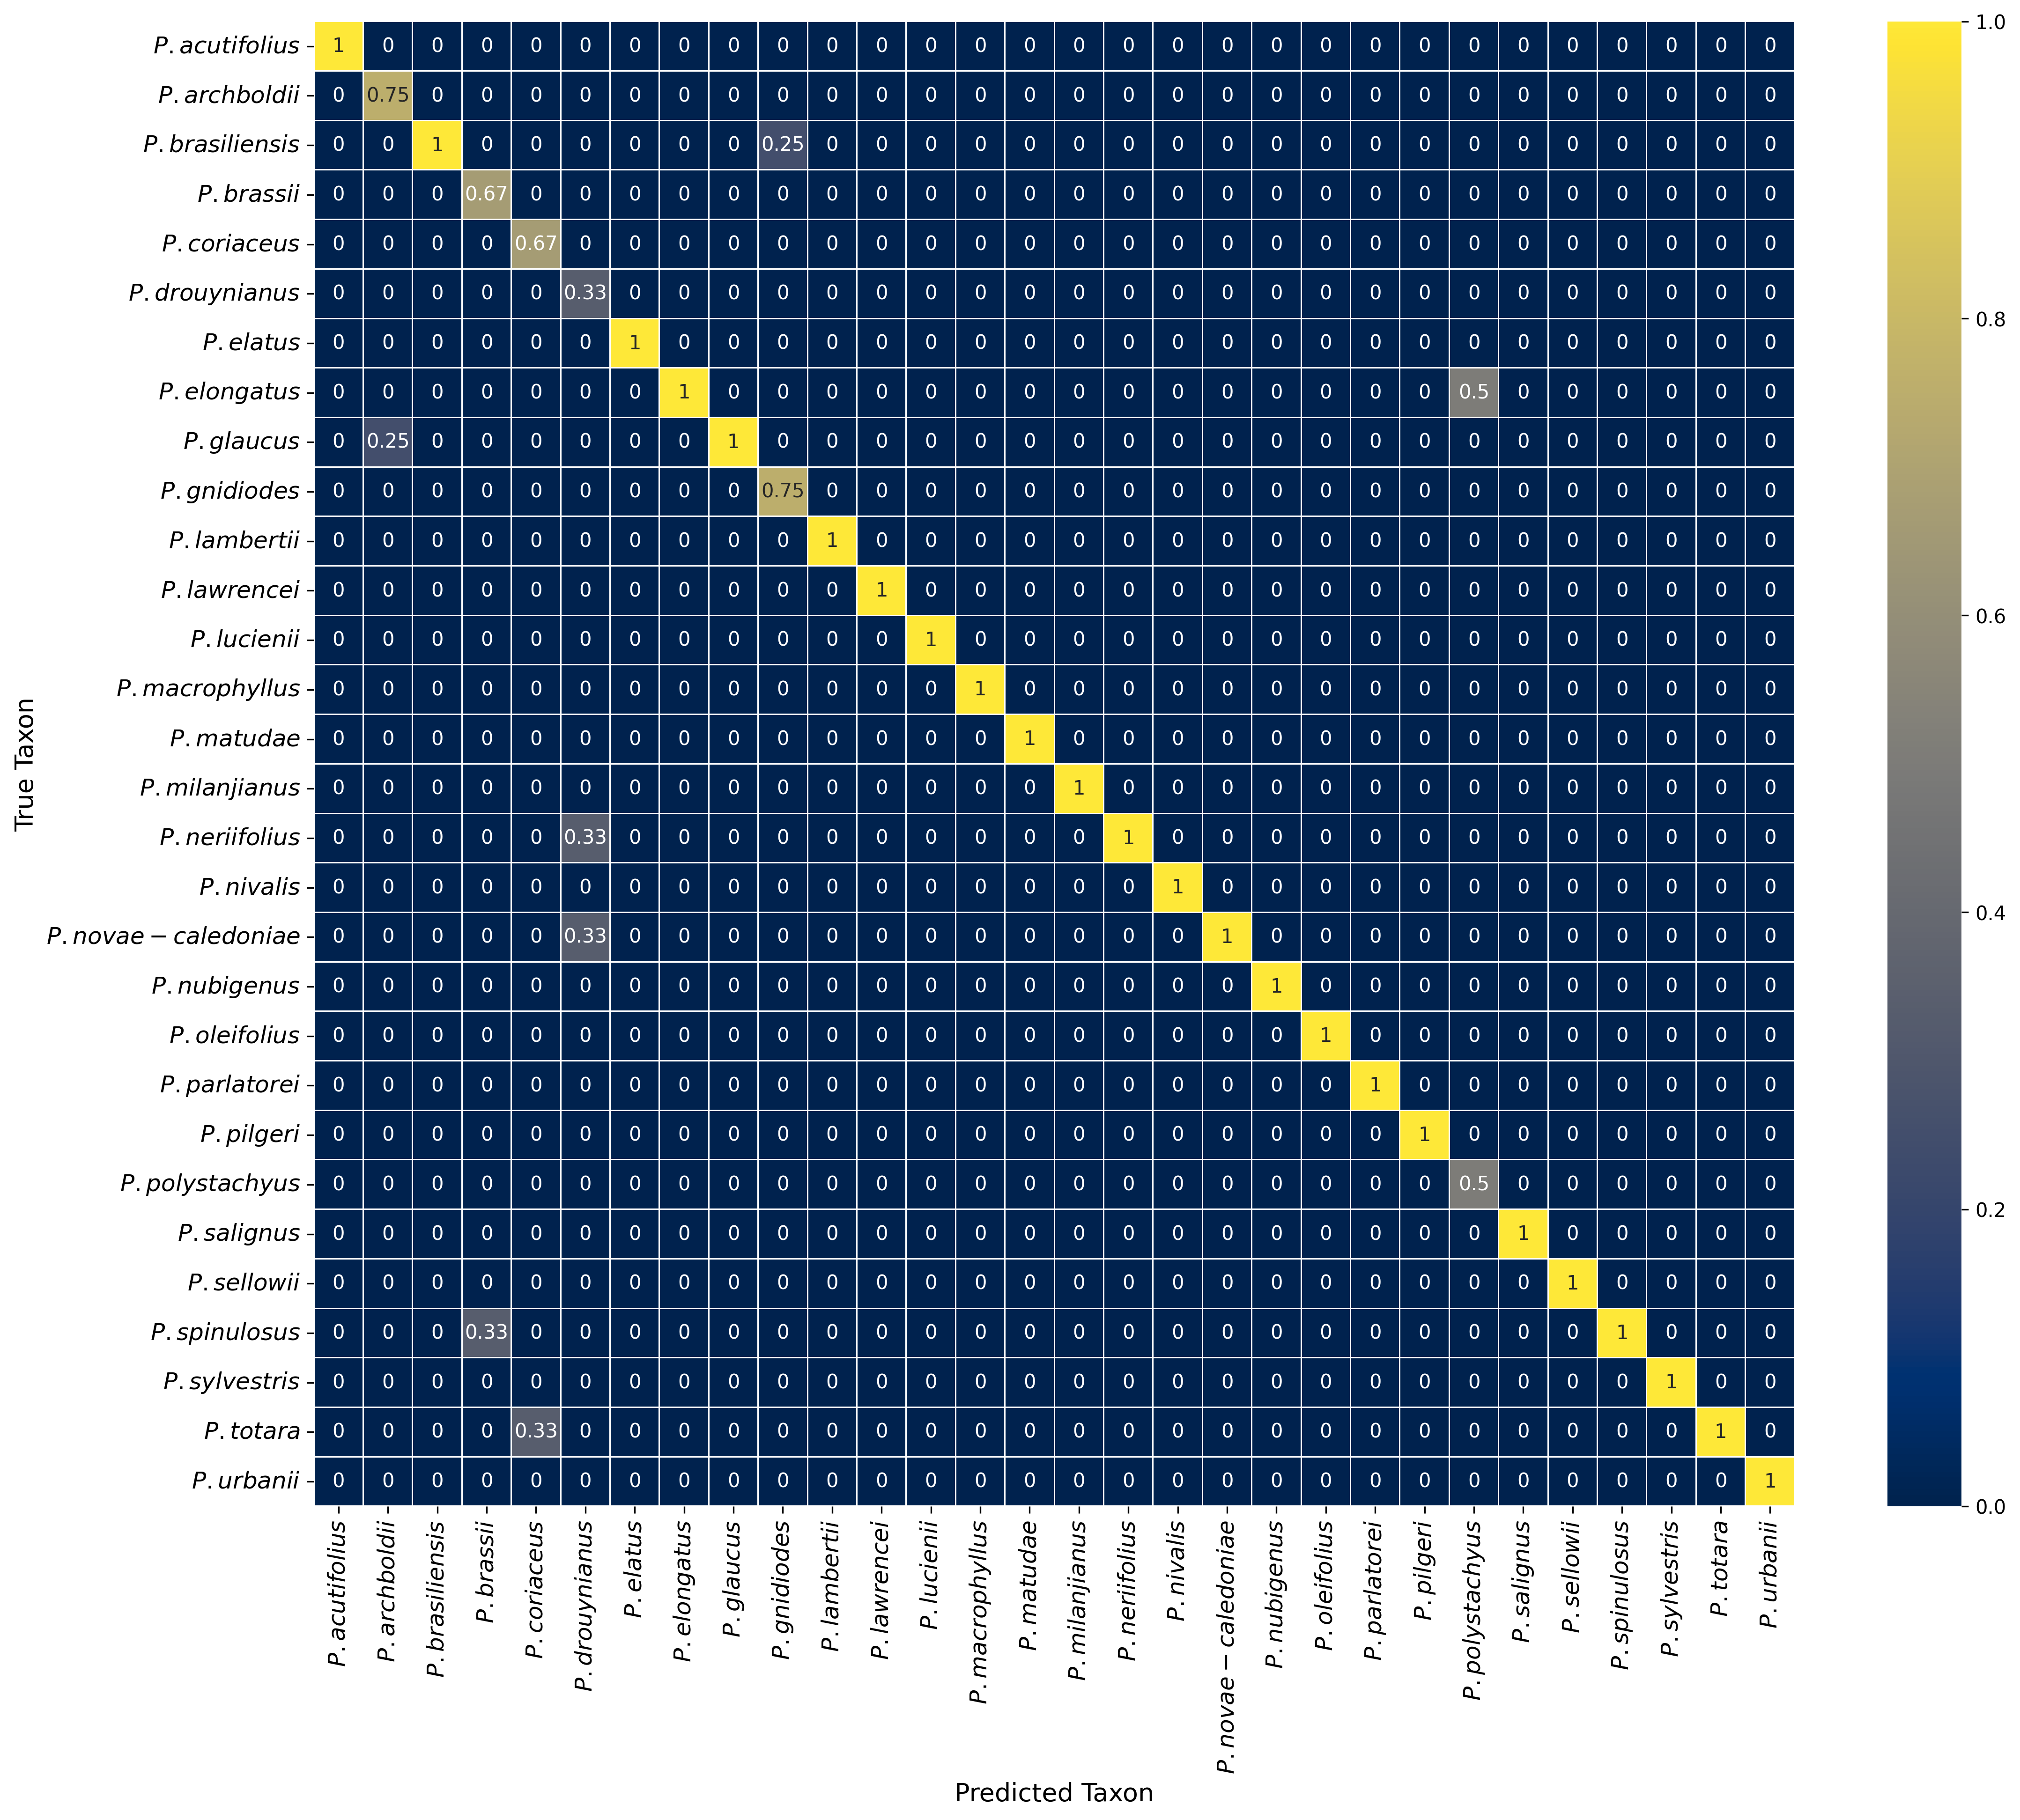

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

GenusName = ["$\it{P. acutifolius}$","$\it{P. archboldii}$","$\it{P. brasiliensis}$","$\it{P. brassii}$","$\it{P. coriaceus}$","$\it{P. drouynianus}$","$\it{P. elatus}$","$\it{P. elongatus}$","$\it{P. glaucus}$","$\it{P. gnidiodes}$","$\it{P. lambertii}$","$\it{P. lawrencei}$","$\it{P. lucienii}$","$\it{P. macrophyllus}$","$\it{P. matudae}$","$\it{P. milanjianus}$","$\it{P. neriifolius}$","$\it{P. nivalis}$","$\it{P. novae-caledoniae}$","$\it{P. nubigenus}$","$\it{P. oleifolius}$","$\it{P. parlatorei}$","$\it{P. pilgeri}$","$\it{P. polystachyus}$","$\it{P. salignus}$","$\it{P. sellowii}$","$\it{P. spinulosus}$","$\it{P. sylvestris}$","$\it{P. totara}$","$\it{P. urbanii}$"];
cm = confusion_matrix(all_preds.argmax(1), labels)
plt.subplots(figsize=(17,14), dpi = 300)
ax = sn.heatmap(cm/sum(cm), annot= True, vmax=1, xticklabels = GenusName, yticklabels = GenusName, cmap='cividis', linewidths=.5);
ax.set_xlabel('Predicted Taxon', fontsize= 13);
ax.set_ylabel('True Taxon', fontsize= 13);
plt.tick_params(axis = 'x', which = 'major', labelsize = 12)
plt.tick_params(axis = 'y', which = 'major', labelsize = 12)

In [ ]:
# Concatenate Cross-Sectional Image Directories and Softmax Probabilities, and Get SORTED Probability vectors
import numpy as np 
Dirs_and_Scores = {}
for i in range (len(all_image_dirs)):
  array_dir = all_image_dirs[i]
  array_pred = all_preds[i]
  Dirs_and_Scores[array_dir] = array_pred
  #Dirs_and_Scores.append(Dir_and_Score)
  
Stack_Probs_Sorted = []
for key in sorted(Dirs_and_Scores.keys()) :
   #print(key , " :: " , Dirs_and_Scores[key])
   #Dirs_and_Scores[key]
   Stack_Probs_Sorted.append(Dirs_and_Scores[key])

#Sort Cross-Sectional Image Labels 
labels.sort()
StackLabels = labels

# Load H-CNN

In [ ]:
PATH = absolute_path + "/models/Podocarpus_H-CNN_Split04.pt"
model =  models.resnext101_32x8d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names)); 
model.load_state_dict(torch.load(PATH));
#model.load_state_dict(torch.load(PATH, map_location="cpu"))
model.to(device);

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Forward pass validation images (MIP images)

In [ ]:
# Forward Pass Images to the network to get (1) Softmax probabilities and (2) best classification prediction

# Average Logits first, then pass the new logit (average) to the softmax function

# Each instance is a subfolder containing a maximum intensity projection (MIP) image

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])


import glob
from PIL import Image

transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

def predict(model, image_dir):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))
    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    logits = model(images)
    logits = logits.detach().cpu().numpy()
    logits = torch.tensor(logits)
    logits_mean = logits.mean(0)
    probs = torch.softmax(logits_mean, 0).detach().cpu().numpy()
    # Compute average and get final prediction
    # avg_probs = probs.mean(0)
    avg_probs = probs
    final_pred = avg_probs.argmax()
    return final_pred, avg_probs

val_dir = absolute_path + "/Podocarpus_Images_Split04/val"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))
model.eval()
class_map = {name: idx for idx, name in enumerate(class_names)}
results = []
all_preds = []
labels = []
all_image_dirs = []

for d in val_class_dirs:
    image_dirs = glob.glob(os.path.join(d, '*'))
    for image_dir in image_dirs:
        class_name = os.path.basename(image_dir).split('.')[0]
        label = class_map[class_name]
        labels.append(label)
        all_image_dirs.append(image_dir)  
        class_id, probs = predict(model, image_dir)
        all_preds.append(probs)
        
        results.append((image_dir, class_id))
        #print(f'Predict {image_dir} as class {class_id}')

all_preds = np.stack(all_preds, 0)
labels = np.array(labels)
print(all_preds.shape, all_preds.dtype, labels.shape, labels.dtype)
print('Accuracy: {}'.format((all_preds.argmax(1) == labels).mean()))

(100, 30) float32 (100,) int64
Accuracy: 0.52


# Compute and visualize confusion matrix (H-CNN)

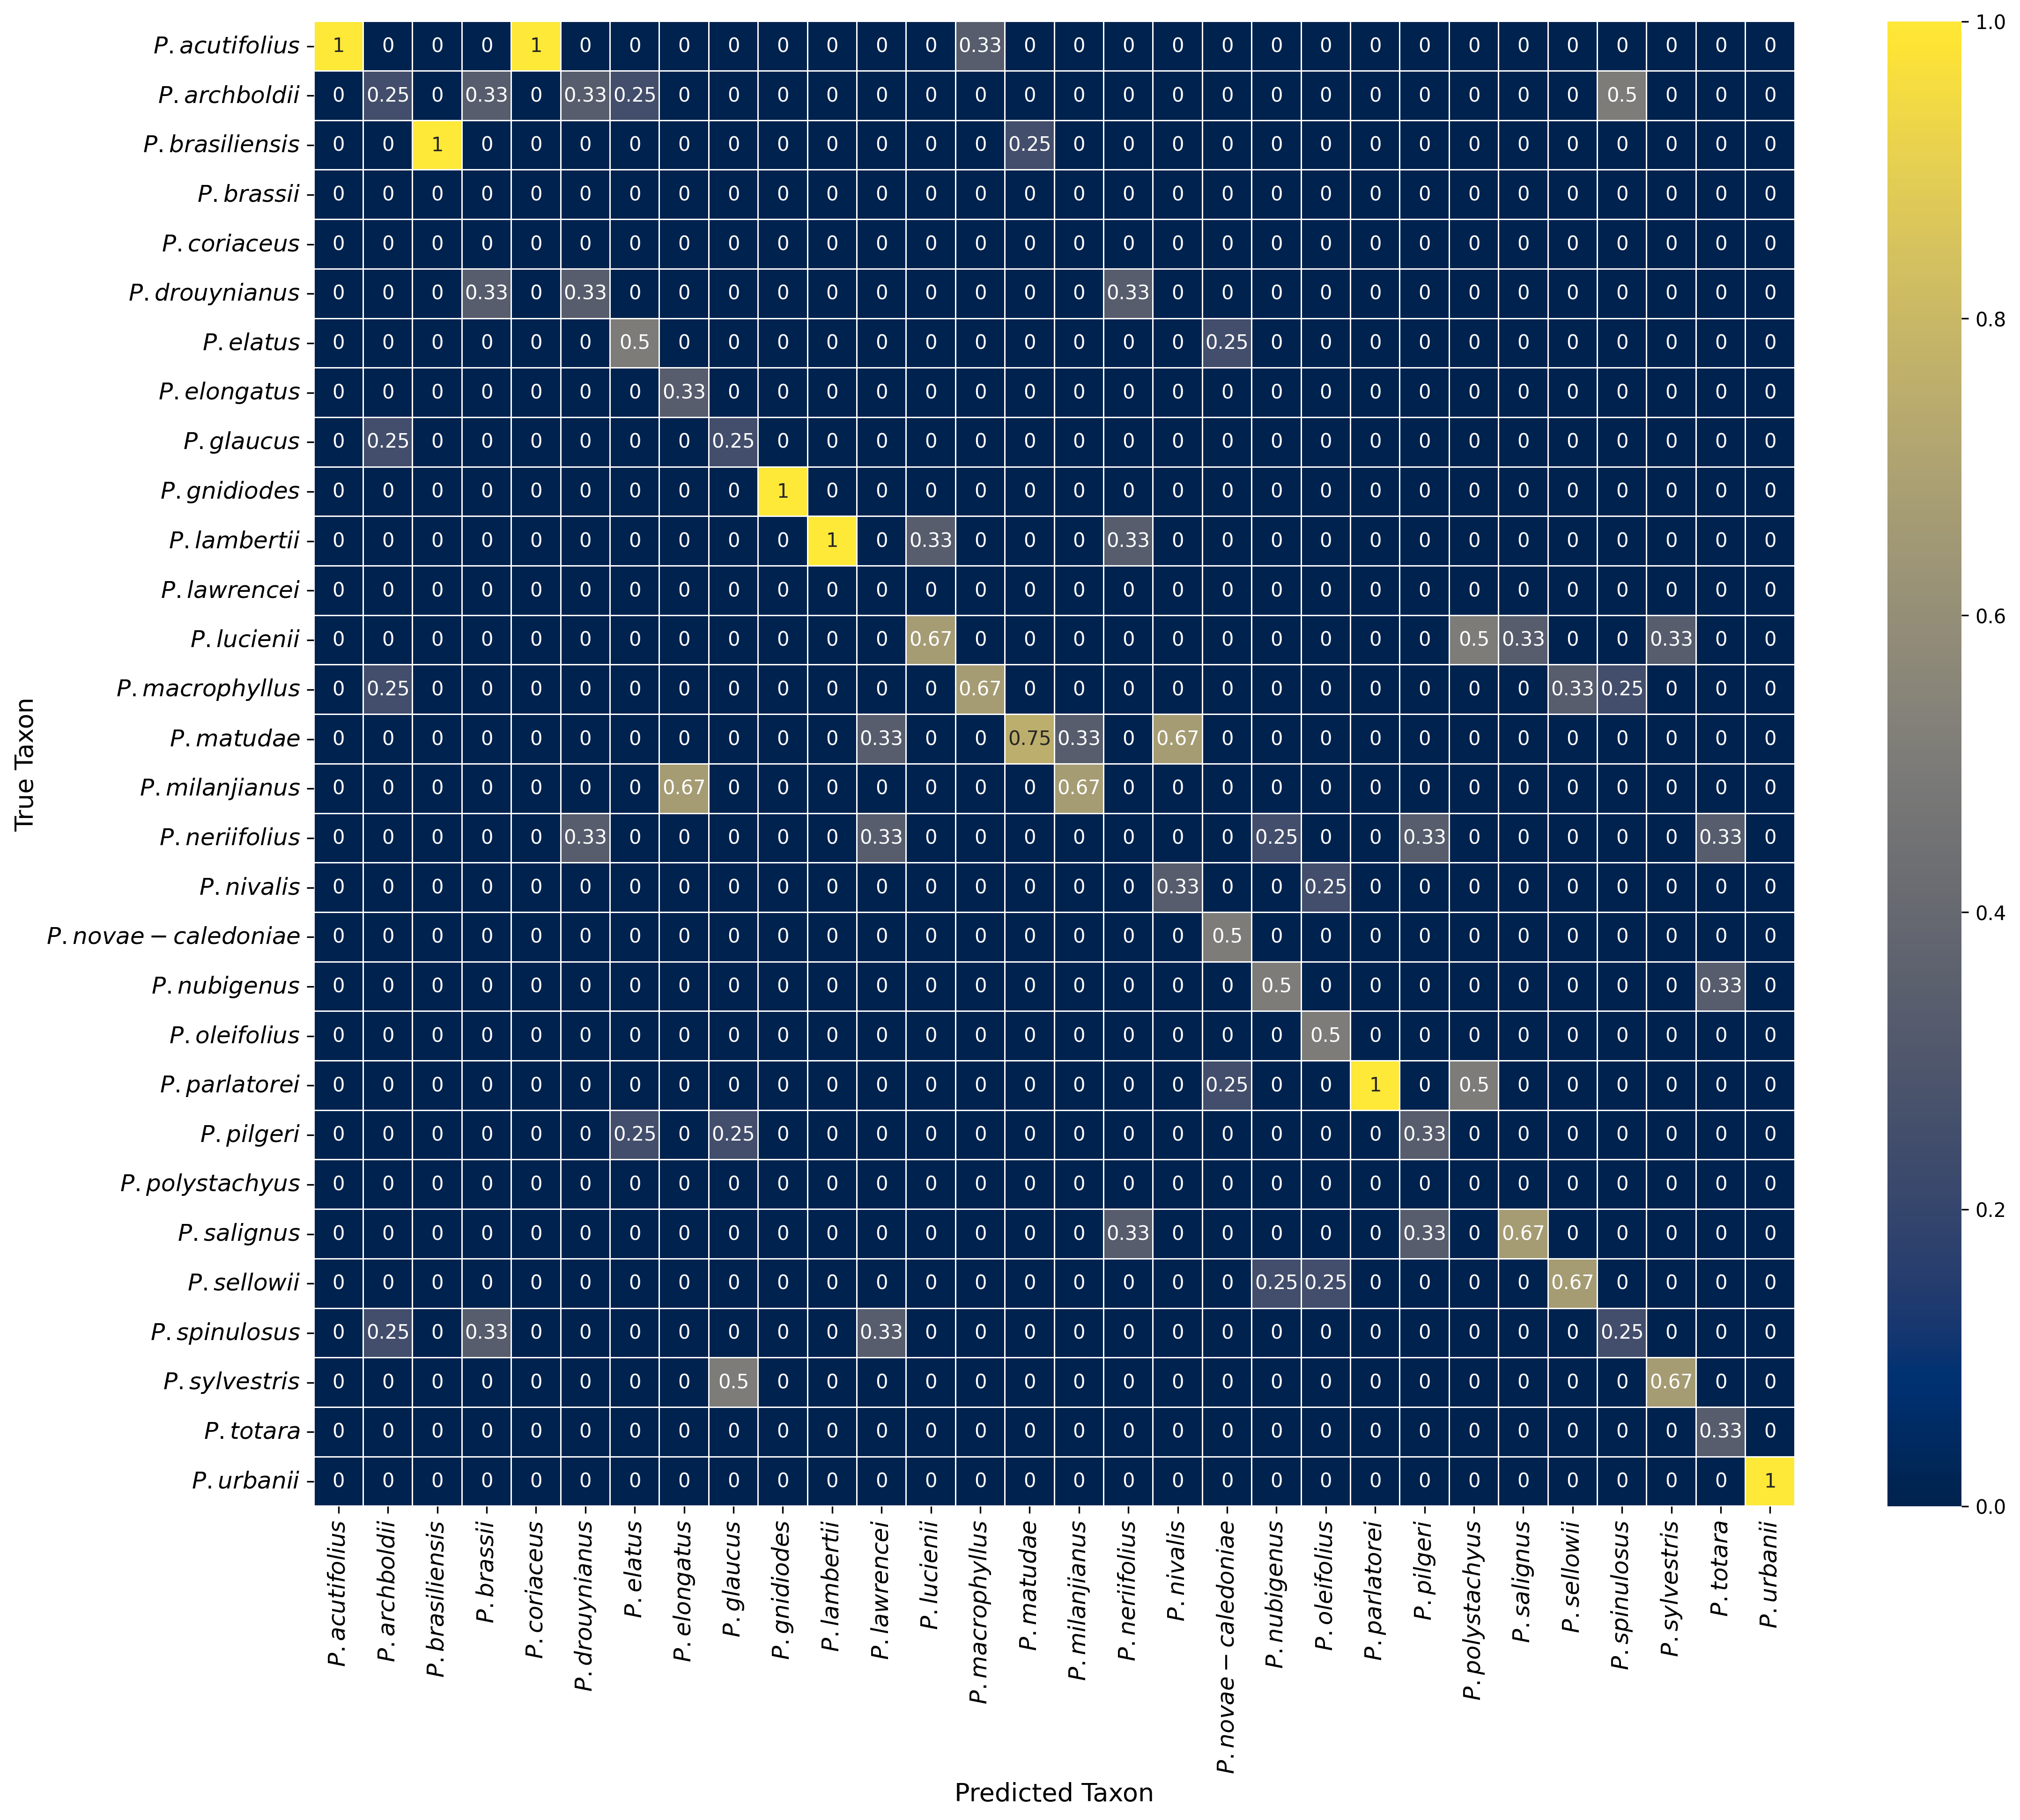

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

GenusName = ["$\it{P. acutifolius}$","$\it{P. archboldii}$","$\it{P. brasiliensis}$","$\it{P. brassii}$","$\it{P. coriaceus}$","$\it{P. drouynianus}$","$\it{P. elatus}$","$\it{P. elongatus}$","$\it{P. glaucus}$","$\it{P. gnidiodes}$","$\it{P. lambertii}$","$\it{P. lawrencei}$","$\it{P. lucienii}$","$\it{P. macrophyllus}$","$\it{P. matudae}$","$\it{P. milanjianus}$","$\it{P. neriifolius}$","$\it{P. nivalis}$","$\it{P. novae-caledoniae}$","$\it{P. nubigenus}$","$\it{P. oleifolius}$","$\it{P. parlatorei}$","$\it{P. pilgeri}$","$\it{P. polystachyus}$","$\it{P. salignus}$","$\it{P. sellowii}$","$\it{P. spinulosus}$","$\it{P. sylvestris}$","$\it{P. totara}$","$\it{P. urbanii}$"];
cm = confusion_matrix(all_preds.argmax(1), labels)
plt.subplots(figsize=(17,14), dpi = 300)
ax = sn.heatmap(cm/sum(cm), annot= True, vmax=1, xticklabels = GenusName, yticklabels = GenusName, cmap='cividis', linewidths=.5);
ax.set_xlabel('Predicted Taxon', fontsize= 13);
ax.set_ylabel('True Taxon', fontsize= 13);
plt.tick_params(axis = 'x', which = 'major', labelsize = 12)
plt.tick_params(axis = 'y', which = 'major', labelsize = 12)

In [ ]:
# Concatenate Image Directories and Softmax Probabilities, and Get SORTED Probability vectors

import numpy as np 
Dirs_and_Scores = {}
for i in range (len(all_image_dirs)):
  array_dir = all_image_dirs[i]
  array_pred = all_preds[i]
  Dirs_and_Scores[array_dir] = array_pred
  #Dirs_and_Scores.append(Dir_and_Score)

Image_Probs_Sorted = []
for key in sorted(Dirs_and_Scores.keys()) :
   #print(key , " :: " , Dirs_and_Scores[key])
   #Dirs_and_Scores[key]
   Image_Probs_Sorted.append(Dirs_and_Scores[key])
   
# Image (Whole Images) Labels 
labels.sort()
ImageLabels = labels

# Load P-CNN

In [ ]:
PATH = absolute_path + "/models/Podocarpus_P-CNN_Split04.pt"
model =  models.resnext101_32x8d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names)); 
model.load_state_dict(torch.load(PATH));
#model.load_state_dict(torch.load(PATH, map_location="cpu"))
model.to(device);

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Forward pass validation images (patches)

In [ ]:
# Forward Pass Images to the network to get (1) Softmax probabilities and (2) best classification prediction

# Average Logits first, then pass the new logit (average) to the softmax function

# Each instance is a subfolder containing multiple (N) patches (patches extracted from *one* image)


mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])


import glob
from PIL import Image

transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

def predict(model, image_dir):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))
    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    logits = model(images)
    logits = logits.detach().cpu().numpy()
    logits = torch.tensor(logits)
    logits_mean = logits.mean(0)
    probs = torch.softmax(logits_mean, 0).detach().cpu().numpy()
    # Compute average and get final prediction
    # avg_probs = probs.mean(0)
    avg_probs = probs
    final_pred = avg_probs.argmax()
    return final_pred, avg_probs

val_dir = absolute_path + "/Podocarpus_Patches_Split04/val"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))
model.eval()
class_map = {name: idx for idx, name in enumerate(class_names)}
results = []
all_preds = []
labels = []
all_image_dirs = []

for d in val_class_dirs:
    image_dirs = glob.glob(os.path.join(d, '*'))
    for image_dir in image_dirs:
        class_name = os.path.basename(image_dir).split('.')[0]
        label = class_map[class_name]
        labels.append(label)
        all_image_dirs.append(image_dir)  
        class_id, probs = predict(model, image_dir)
        all_preds.append(probs)

        results.append((image_dir, class_id))
        #print(f'Predict {image_dir} as class {class_id}')

all_preds = np.stack(all_preds, 0)
labels = np.array(labels)
print(all_preds.shape, all_preds.dtype, labels.shape, labels.dtype)
print('Accuracy: {}'.format((all_preds.argmax(1) == labels).mean()))

(100, 30) float32 (100,) int64
Accuracy: 0.83


# Compute and visualize confusion matrix (P-CNN)



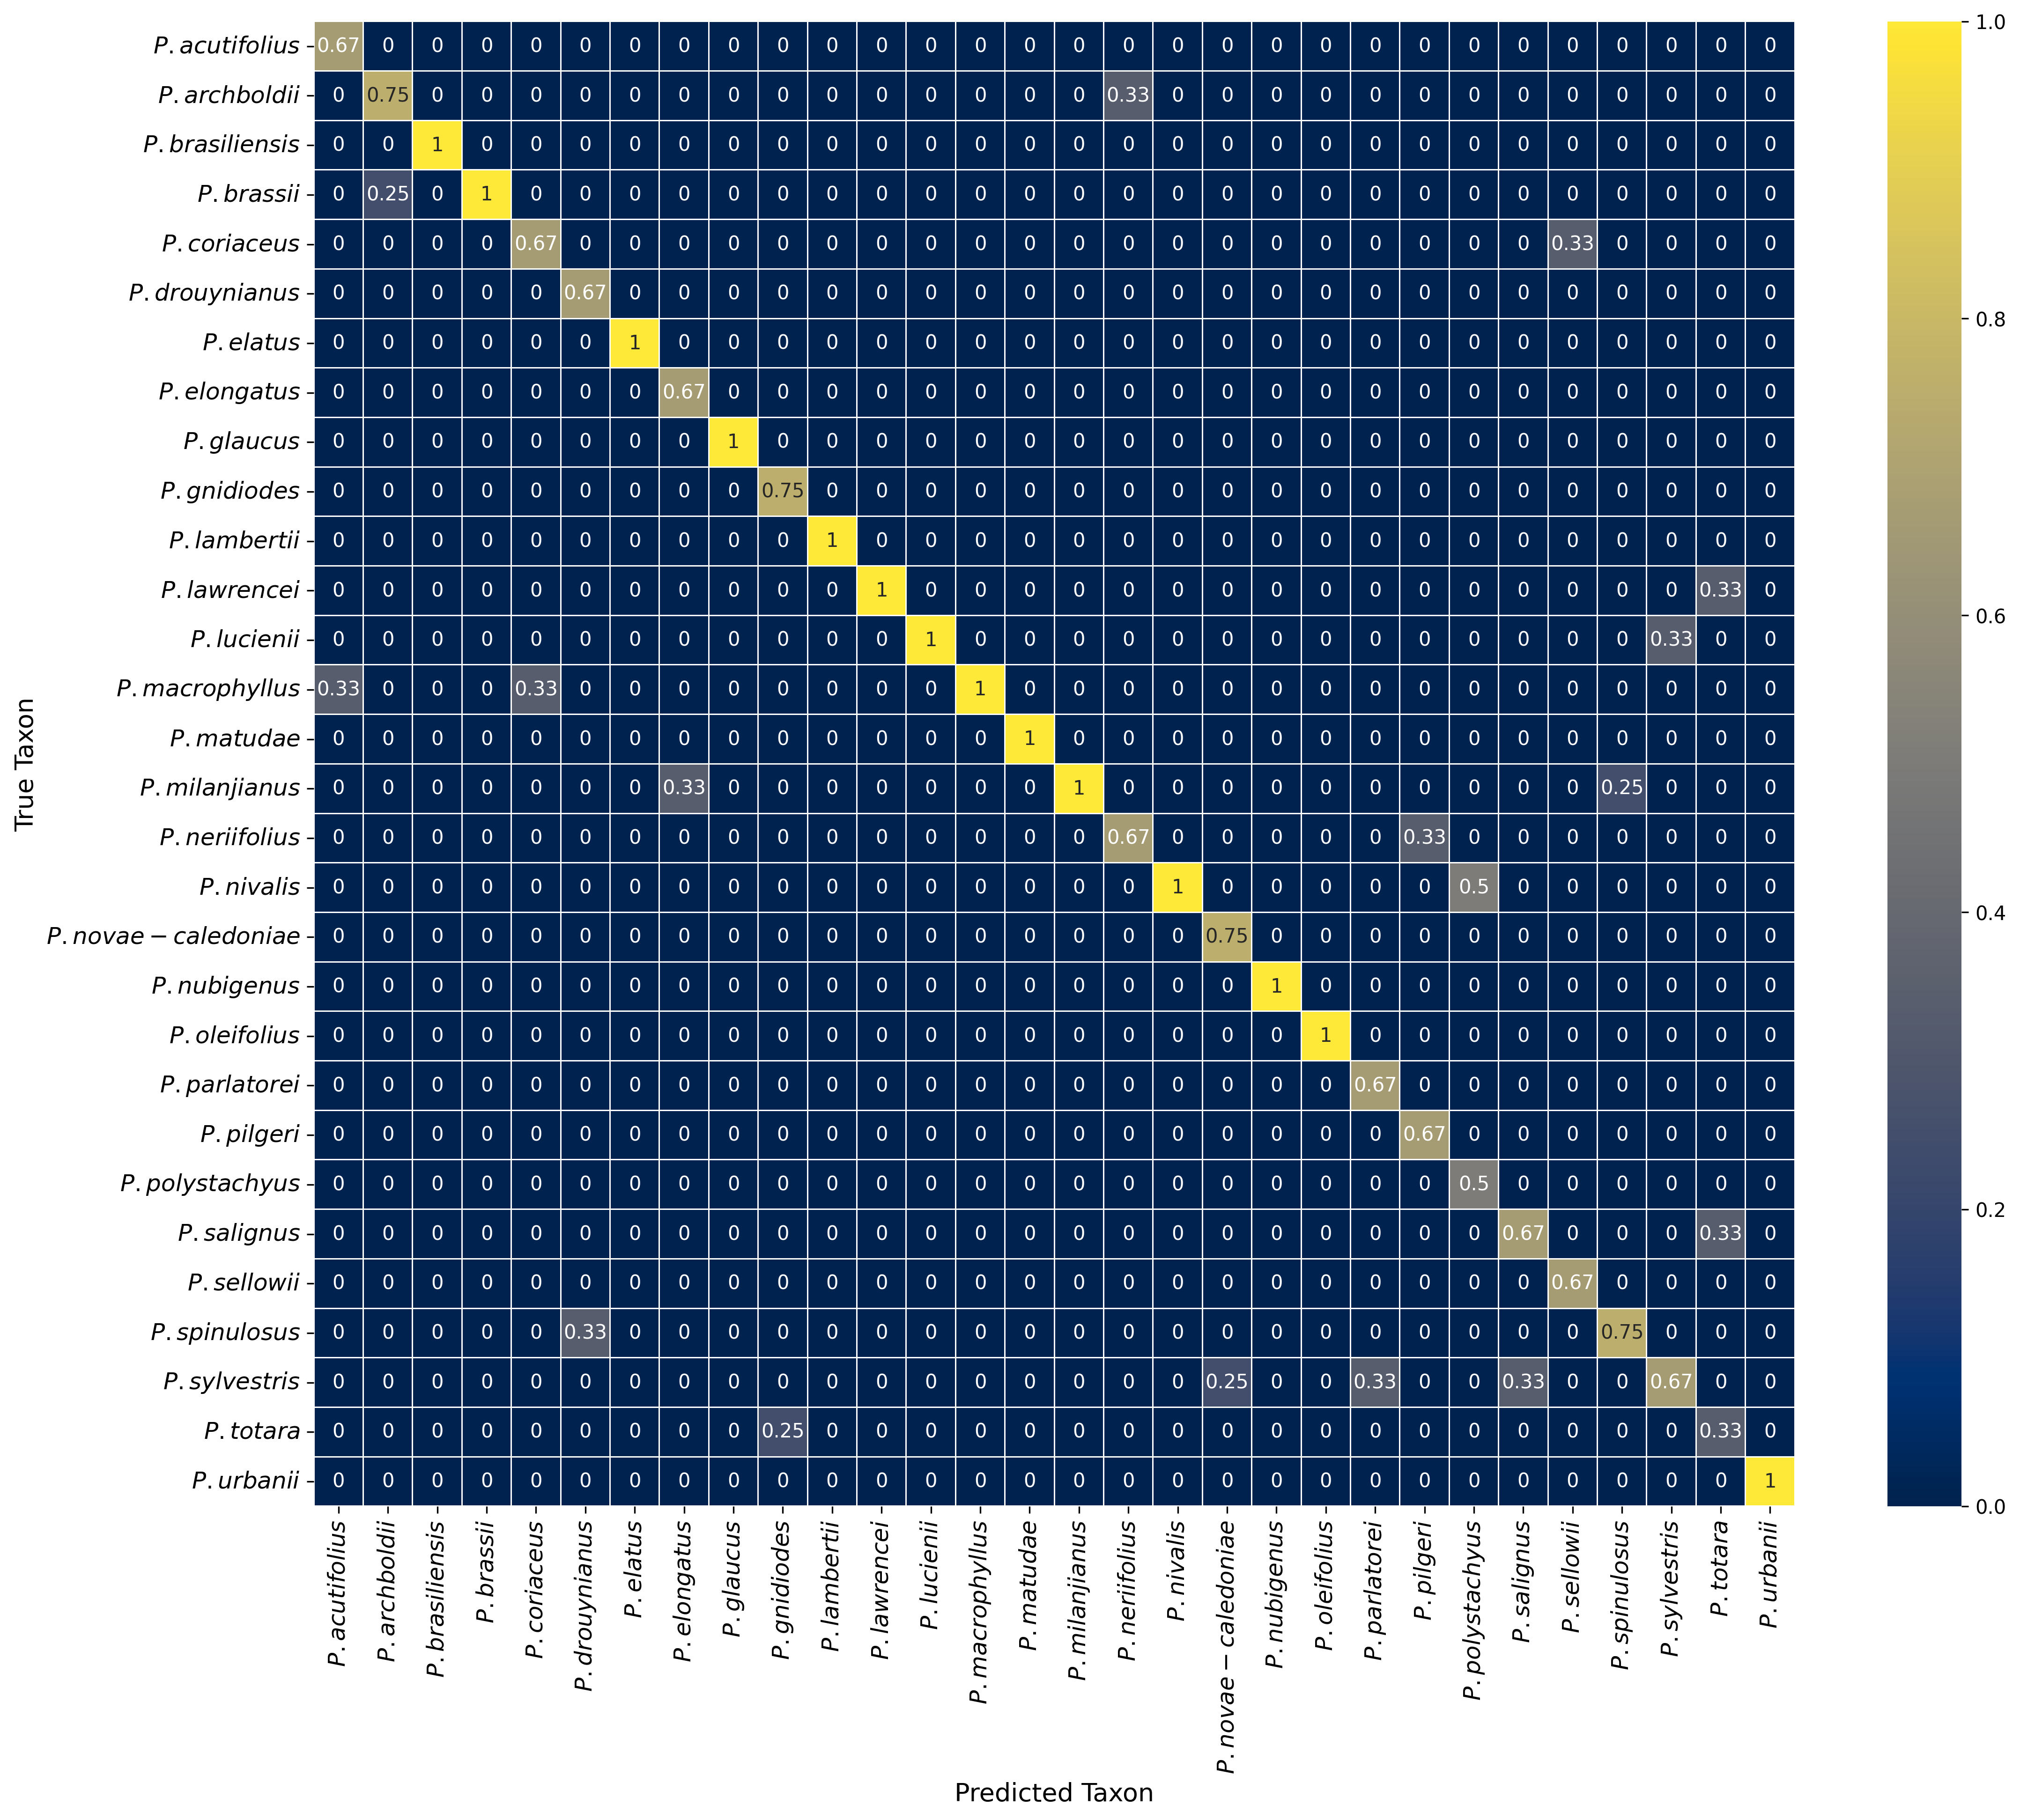

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

GenusName = ["$\it{P. acutifolius}$","$\it{P. archboldii}$","$\it{P. brasiliensis}$","$\it{P. brassii}$","$\it{P. coriaceus}$","$\it{P. drouynianus}$","$\it{P. elatus}$","$\it{P. elongatus}$","$\it{P. glaucus}$","$\it{P. gnidiodes}$","$\it{P. lambertii}$","$\it{P. lawrencei}$","$\it{P. lucienii}$","$\it{P. macrophyllus}$","$\it{P. matudae}$","$\it{P. milanjianus}$","$\it{P. neriifolius}$","$\it{P. nivalis}$","$\it{P. novae-caledoniae}$","$\it{P. nubigenus}$","$\it{P. oleifolius}$","$\it{P. parlatorei}$","$\it{P. pilgeri}$","$\it{P. polystachyus}$","$\it{P. salignus}$","$\it{P. sellowii}$","$\it{P. spinulosus}$","$\it{P. sylvestris}$","$\it{P. totara}$","$\it{P. urbanii}$"];
cm = confusion_matrix(all_preds.argmax(1), labels)
plt.subplots(figsize=(17,14), dpi = 300)
ax = sn.heatmap(cm/sum(cm), annot= True, vmax=1, xticklabels = GenusName, yticklabels = GenusName, cmap='cividis', linewidths=.5);
ax.set_xlabel('Predicted Taxon', fontsize= 13);
ax.set_ylabel('True Taxon', fontsize= 13);
plt.tick_params(axis = 'x', which = 'major', labelsize = 12)
plt.tick_params(axis = 'y', which = 'major', labelsize = 12)

In [ ]:
# Concatenate Image Directories and Softmax Probabilities, and Get SORTED Probability vectors

import numpy as np 
Dirs_and_Scores = {}
for i in range (len(all_image_dirs)):
  array_dir = all_image_dirs[i]
  array_pred = all_preds[i]
  Dirs_and_Scores[array_dir] = array_pred
  #Dirs_and_Scores.append(Dir_and_Score)

Patch_Probs_Sorted = []
for key in sorted(Dirs_and_Scores.keys()) :
   #print(key , " :: " , Dirs_and_Scores[key])
   #Dirs_and_Scores[key]
   Patch_Probs_Sorted.append(Dirs_and_Scores[key])

# Image (Whole Images) Labels 
labels.sort()
PatchLabels = labels

# Fuse scores across three modalities and compute classification accuracy (FM)


In [ ]:
import torch
import torch.nn.functional as f

# Fuse softmax score vectors across all three modalities (all three CNNs): 

Fused_Probabilities = torch.tensor(Stack_Probs_Sorted) * torch.tensor(Image_Probs_Sorted) * torch.tensor(Patch_Probs_Sorted) 

# Normalize to [0-1] probability vectors 

Fused_Probabilities_Normalized = f.normalize(torch.tensor(Fused_Probabilities), p=2, dim=1)

# Save Fused Probabilities as File
np.savetxt(absolute_path + "/Fused_Probabilities_Normalized.csv", Fused_Probabilities_Normalized, delimiter=",")

#print(Fused_Probabilities_Normalized.shape)
Fused_Probabilities_Normalized_array = np.array(Fused_Probabilities_Normalized)

# Compute Fused Classification Accuracy (F-CNN)
Indices = []
for i in range(len(Fused_Probabilities_Normalized_array)):
  index, = np.where(Fused_Probabilities_Normalized_array[i] == Fused_Probabilities_Normalized_array[i].max())
  Indices.append(index.item())
    
Accuracy = []
for i in range(len(Indices)):
   Per_Instance_Accuracy = Indices[i] == ImageLabels[i]
   Accuracy.append(Per_Instance_Accuracy)

Fused_Classification_Accuracy = sum(Accuracy)/len(Fused_Probabilities_Normalized_array)
print('Fused Classification Accuracy: {}'.format(Fused_Classification_Accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Fused Classification Accuracy: 0.94


# Compute and visualize confusion matrix (FM)


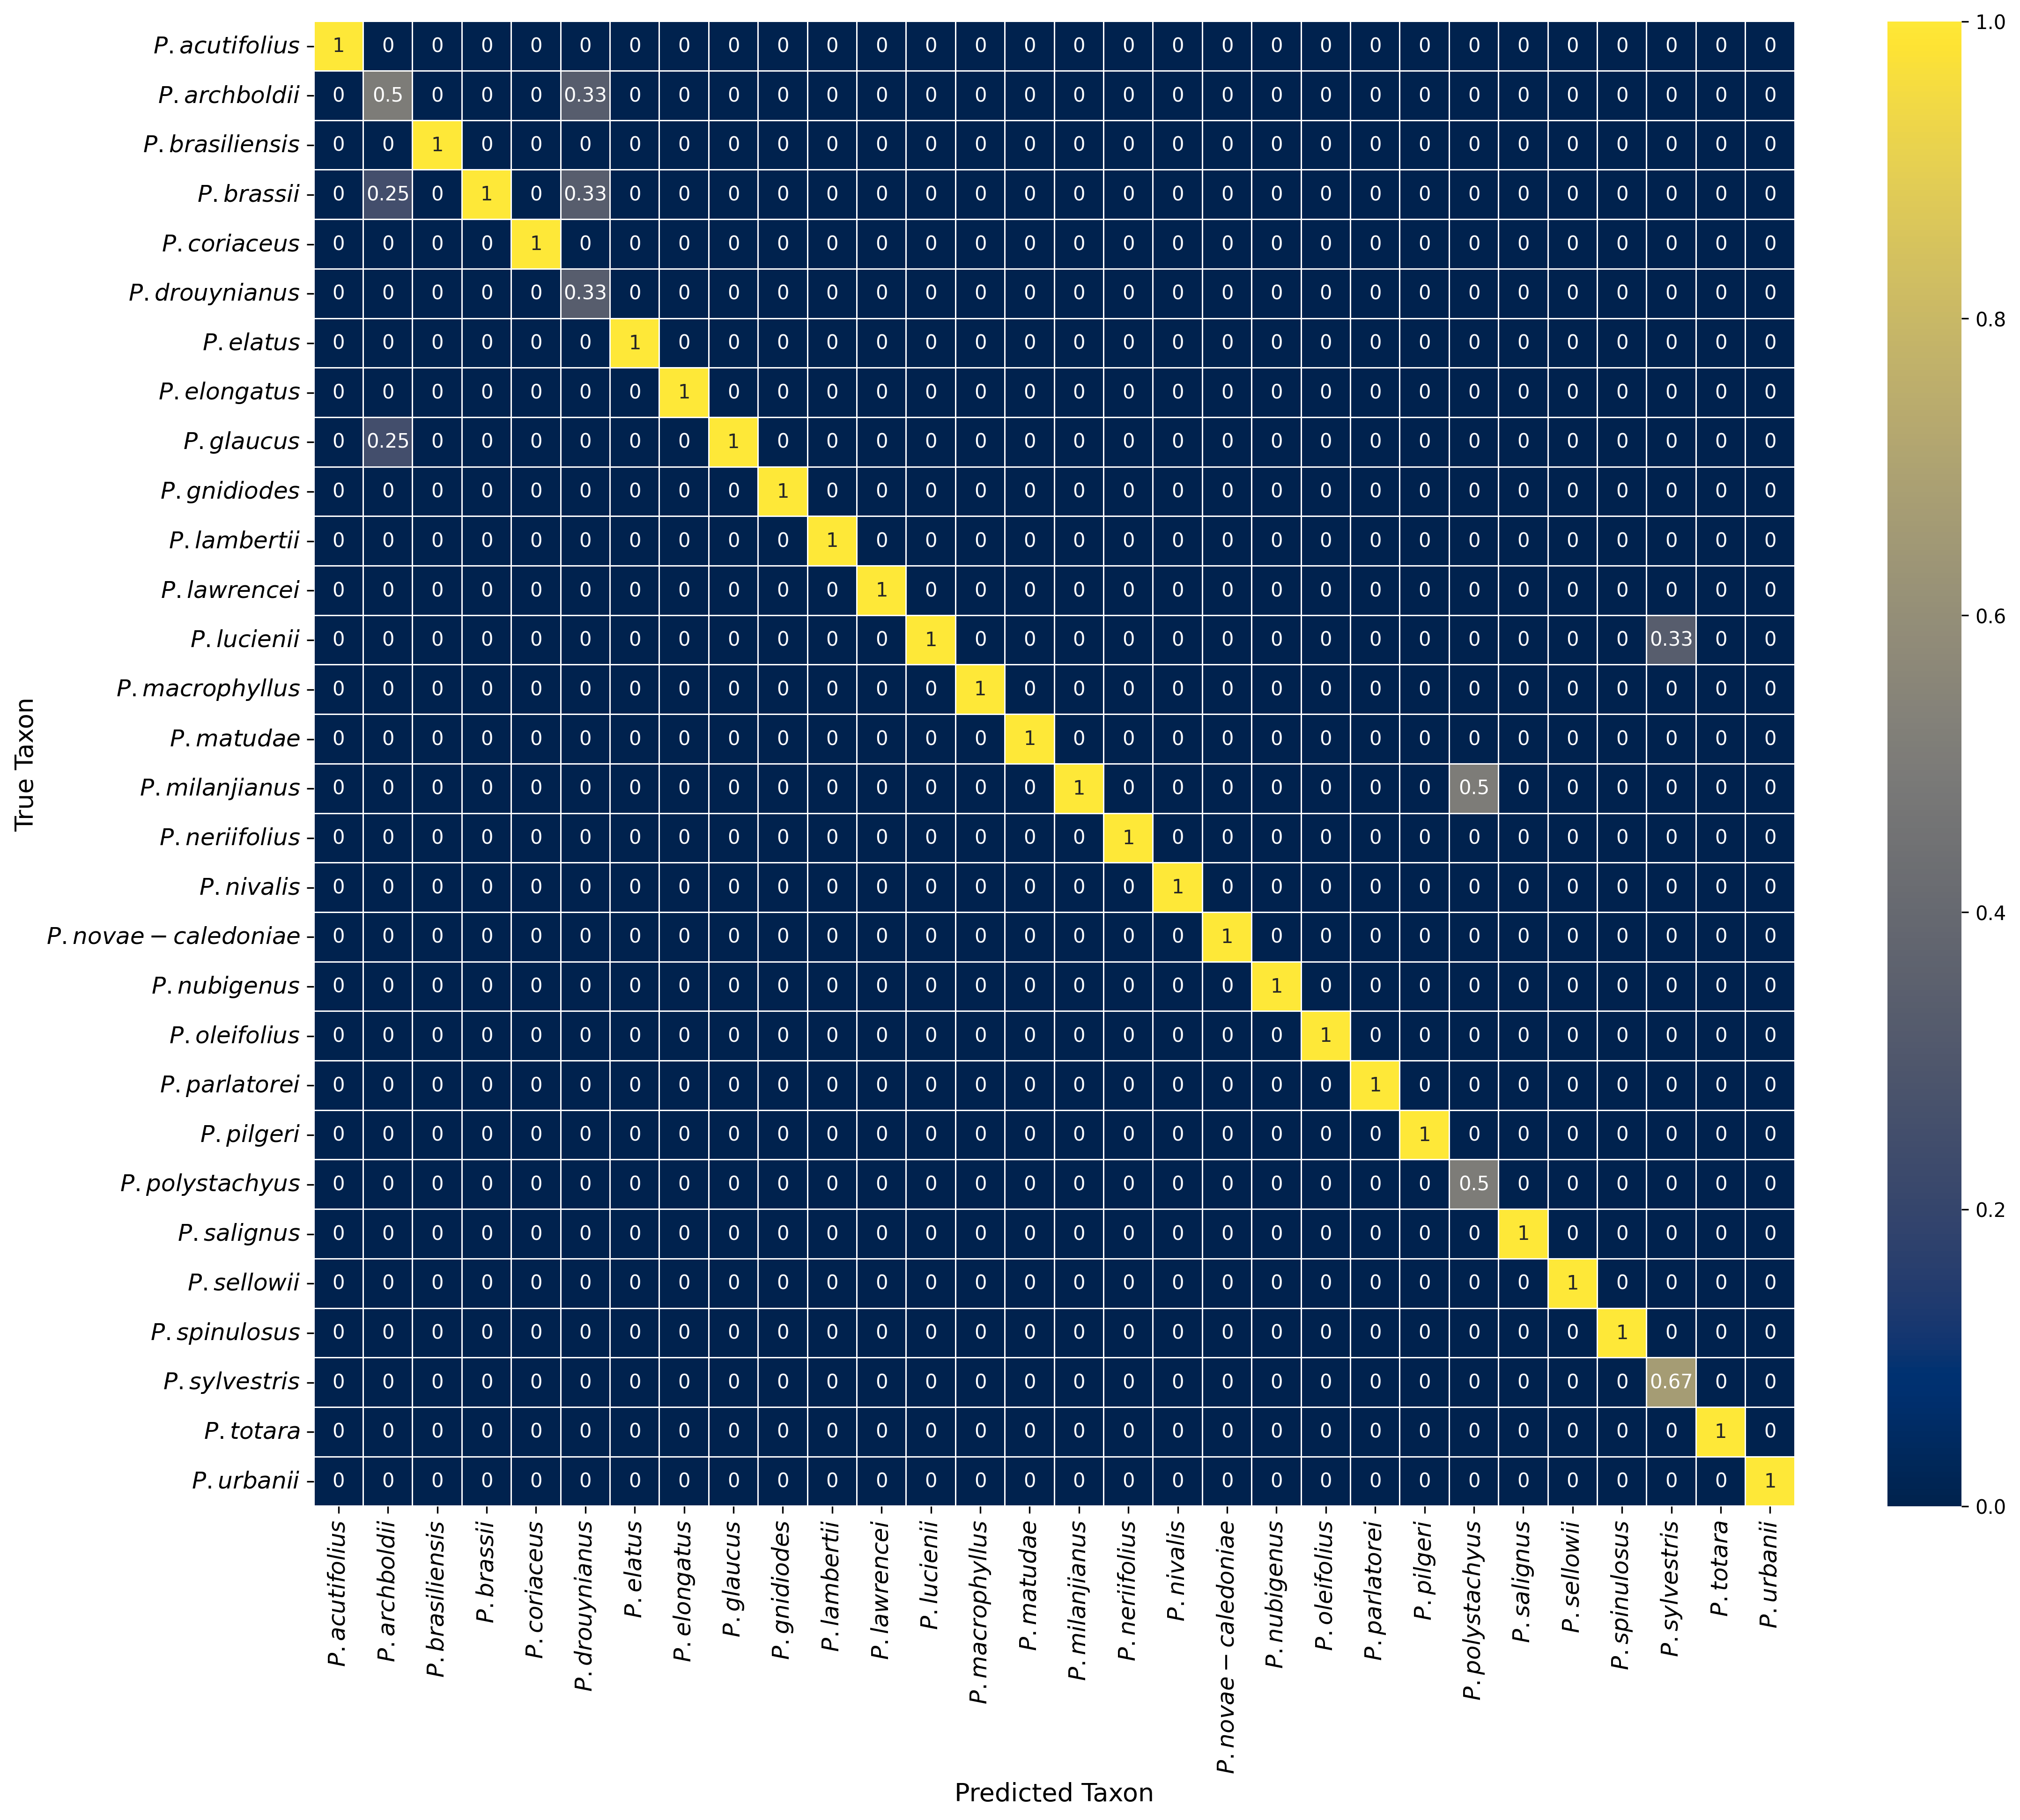

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

GenusName = ["$\it{P. acutifolius}$","$\it{P. archboldii}$","$\it{P. brasiliensis}$","$\it{P. brassii}$","$\it{P. coriaceus}$","$\it{P. drouynianus}$","$\it{P. elatus}$","$\it{P. elongatus}$","$\it{P. glaucus}$","$\it{P. gnidiodes}$","$\it{P. lambertii}$","$\it{P. lawrencei}$","$\it{P. lucienii}$","$\it{P. macrophyllus}$","$\it{P. matudae}$","$\it{P. milanjianus}$","$\it{P. neriifolius}$","$\it{P. nivalis}$","$\it{P. novae-caledoniae}$","$\it{P. nubigenus}$","$\it{P. oleifolius}$","$\it{P. parlatorei}$","$\it{P. pilgeri}$","$\it{P. polystachyus}$","$\it{P. salignus}$","$\it{P. sellowii}$","$\it{P. spinulosus}$","$\it{P. sylvestris}$","$\it{P. totara}$","$\it{P. urbanii}$"];
cm = confusion_matrix(Indices, labels)
plt.subplots(figsize=(17,14), dpi = 300)
ax = sn.heatmap(cm/sum(cm), annot= True, vmax=1, xticklabels = GenusName, yticklabels = GenusName, cmap='cividis', linewidths=.5);
ax.set_xlabel('Predicted Taxon', fontsize= 13);
ax.set_ylabel('True Taxon', fontsize= 13);
plt.tick_params(axis = 'x', which = 'major', labelsize = 12)
plt.tick_params(axis = 'y', which = 'major', labelsize = 12)